# Multiclass clssification using sklearn
1. Classify pain, vicarious, cognitive maps based on single trials 
2. Classify pain, vicarious, cogntiive maps based on contrast maps

In [1]:
from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import os, glob, re, json
from os.path import join
import numpy as np
import pandas as pd
from nilearn import image, masking, maskers, plotting
from nilearn.image import resample_to_img, math_img, new_img_like
from datetime import datetime
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import h5py

In [2]:
import gc
gc.collect()
# del braindf

0

# 1. load single trial data

check `scripts/step10_nilearn/PLS/PLS.ipynb` and `scripts/step10_nilearn/PLS/PLS_pvc.ipynb` on how the brain and behavioral data was created

In [3]:
braindf_fname = '/Volumes/seagate/cue_singletrials/singletrial_pvc.h5'
behdf_fname = '/Volumes/seagate/cue_singletrials/singletrial_pvc.csv'

with h5py.File(braindf_fname, 'r') as hdf:
    braindf = hdf['singletrial'][:]

behdf = pd.read_csv(behdf_fname)

In [4]:
braindf.shape

(38856, 98053)

In [5]:
dummy_vars = pd.get_dummies(behdf['runtype'])
merged_df = pd.concat([behdf, dummy_vars], axis=1)
# rename the dummy columns for clarity:
merged_df.rename(columns={'pain': 'dummy_pain', 'vicarious': 'dummy_vicarious', 'cognitive': 'dummy_cognitive'}, inplace=True)
# adding domain general regressor
merged_df['dummy_general'] = 1


In [6]:
merged_df.head()

,basename,onset,duration,trial_type,sub,ses,run,runtype,eventtype,trialnum,...,singletrial_fname,singletrial_fname_no_ext,pain_cue,vic_cue,cog_cue,gen_cue,dummy_cognitive,dummy_pain,dummy_vicarious,dummy_general
0,sub-0002_ses-03_run-01_runtype-vicarious_event...,11.61111,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,0,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,-1,0,-1,False,False,True,1
1,sub-0002_ses-03_run-01_runtype-vicarious_event...,42.40593,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,1,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1,False,False,True,1
2,sub-0002_ses-03_run-01_runtype-vicarious_event...,74.20112,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,2,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1,False,False,True,1
3,sub-0002_ses-03_run-01_runtype-vicarious_event...,110.61470,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,3,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1,False,False,True,1
4,sub-0002_ses-03_run-01_runtype-vicarious_event...,139.90896,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,4,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,-1,0,-1,False,False,True,1


In [88]:
merged_df.columns

Index(['basename', 'onset', 'duration', 'trial_type', 'sub', 'ses', 'run',
       'runtype', 'eventtype', 'trialnum', 'cuetype', 'stimtype',
       'expectrating', 'outcomerating', 'singletrial_fname',
       'singletrial_fname_no_ext', 'pain_cue', 'vic_cue', 'cog_cue', 'gen_cue',
       'dummy_cognitive', 'dummy_pain', 'dummy_vicarious', 'dummy_general',
       'groupsinterim'],
      dtype='object')

## plot behavioral

In [33]:
merged_df['runtype']

0        vicarious
1        vicarious
2        vicarious
3        vicarious
4        vicarious
           ...    
38851    cognitive
38852    cognitive
38853    cognitive
38854    cognitive
38855    cognitive
Name: runtype, Length: 38856, dtype: object

In [92]:
codes, uniques = pd.factorize(merged_df['runtype'][:500])
print(codes)
print(uniques)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [93]:
unique_values, counts = np.unique(codes, return_counts=True)
print(counts)

[188 144 168]


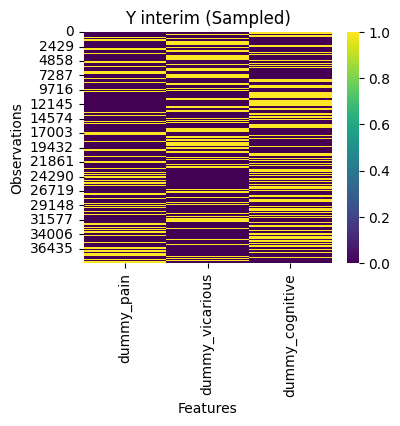

In [7]:
Ydummy = merged_df[
    ["dummy_pain", "dummy_vicarious", "dummy_cognitive"] #, "dummy_general"]
] 
Yinterim, uniques = pd.factorize(merged_df['runtype'])
Xinterim = braindf  

# create groups (per subject)
codes, _ = pd.factorize(merged_df['sub'])
merged_df['groupsinterim'] = codes + 1

# Plotting
plt.figure(figsize=(4,3))
sns.heatmap(Ydummy, cmap="viridis", cbar=True)
plt.title("Y interim (Sampled)")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()


array([0, 0, 0, ..., 2, 2, 2])

## remove nans

In [8]:
print("7. remove nan values from X and Y")

nan_rows = np.isnan(Yinterim)
X = Xinterim[~nan_rows]
Y = Yinterim[~nan_rows]

groups = merged_df['groupsinterim'][~nan_rows]

clean_indices = np.where(~nan_rows)

print(f"after removing nan values based on the behavioral matrix, X shape is now: {X.shape}")
print(f"previously X was: {Xinterim.shape}")

7. remove nan values from X and Y
after removing nan values based on the behavioral matrix, X shape is now: (38856, 98053)
previously X was: (38856, 98053)


In [11]:
# del braindf
del behdf

In [12]:
X = X[:5000]
Y = Y[:5000]
groups = groups[:5000]

In [14]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# This code essentially performs 10-fold cross-validation with a Support Vector Machine classifier to evaluate the model's performance on the given brain data and labels, ensuring that the cross-validation process is stratified and group-wise. The mean accuracy provides an estimate of how well the SVM model generalizes to unseen data.
# # X: brain data. shape: (number of trials, number of voxels)
# # Y: 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# 10-fold stratified cross validation
# folds are applied on subject level data
# A linear SVM classifer is trained on the training data and applied on the test data, by predicting the labels on the test data.
# accuracies compiles the model accuracy of predicting the labels across the 10 folds. 


# Initialize arrays to store results
accuracies = []

# Loop through each fold

import time
start_time = time.perf_counter()
outer_cv = GroupKFold(n_splits=10)
# pls_model = PLSRegression(n_components=3)
i = 0
scores = []
weights_per_fold = []
coefficients = []
yloadings = []
y_pred_probas = []
y_tests = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, Y, groups)):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    # Initialize and train a Support Vector Machine (SVM) classifier
    svm = SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest
    svm.fit(X_train, Y_train)
    
    # Predict using the trained model
    Y_pred = svm.predict(X_test)
    Y_pred_proba = svm.predict_proba(X_test)
    y_pred_probas.append(Y_pred_proba)
    # Calculate accuracy for this fold
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)
    weights = svm.coef_
    weights_per_fold.append(weights)
    y_tests.append(Y_test)
# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)

# Display the mean accuracy
print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%")
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Mean Accuracy: 56.66%
Elapsed time: 3925.9856934590007 seconds


In [19]:
weights_per_fold[0].shape

(3, 98053)

# visualization
here I plot the 
* ROC curve and AUC
* Y vs Ypred scores and correlation
* SVM weight maps in MNI space

In [68]:
import nilearn
from nilearn import image
from nilearn.input_data import NiftiMasker
weights_per_fold[0].shape
sample_nii = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown/sub-0112/sub-0112_ses-01_run-01_runtype-cognitive_event-stimulus_trial-000_cuetype-high_stimintensity-low.nii.gz'
mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask.nii')
binarized_mask = image.math_img("img > 0", img=mask)

masker = NiftiMasker(mask_img=binarized_mask)
masked_data = masker.fit()


In [80]:
mask.get_fdata().shape

(121, 145, 121)

NiftiMasker(mask_img=<nibabel.nifti1.Nifti1Image object at 0x139f96bd0>,
            target_affine=array([[   2.68300009,    0.        ,    0.        ,  -96.5       ],
       [   0.        ,    2.68300009,    0.        , -132.5       ],
       [   0.        ,    0.        ,    2.70000005,  -78.5       ],
       [   0.        ,    0.        ,    0.        ,    1.        ]]),
            target_shape=(73, 86, 73))

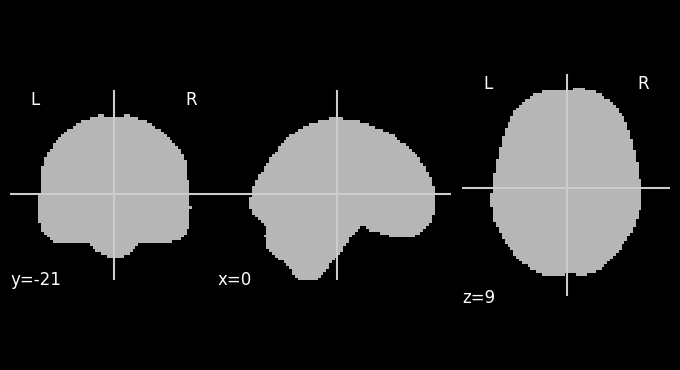

In [83]:
imgfname = "/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz"
ref_img = image.load_img(imgfname)
mask = image.load_img(
    "/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii"
)
mask_img = masking.compute_epi_mask(
    mask, target_affine=ref_img.affine, target_shape=ref_img.shape
)
plotting.plot_anat(mask_img)

# Apply the mask using NiftiMasker
nifti_masker = maskers.NiftiMasker(
    mask_img=mask_img,
    # smoothing_fwhm=6,
    target_affine=ref_img.affine,
    target_shape=ref_img.shape,
)
nifti_masker.fit()

In [54]:
uniques

Index(['vicarious', 'pain', 'cognitive'], dtype='object')

In [86]:

vic_img = nifti_masker.inverse_transform(weights_per_fold[0][0])
pain_img = nifti_masker.inverse_transform(weights_per_fold[0][1])
cog_img = nifti_masker.inverse_transform(weights_per_fold[0][2])


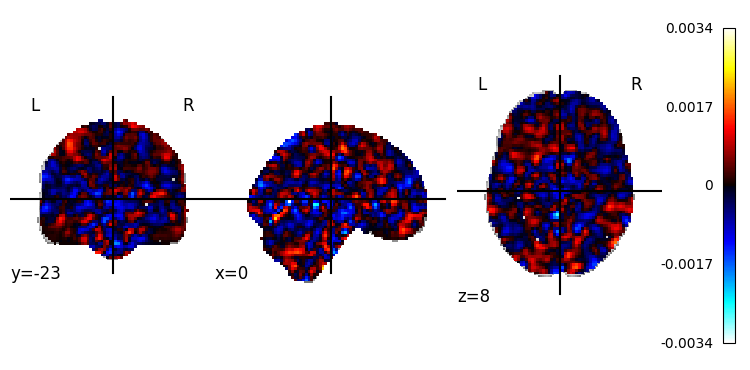

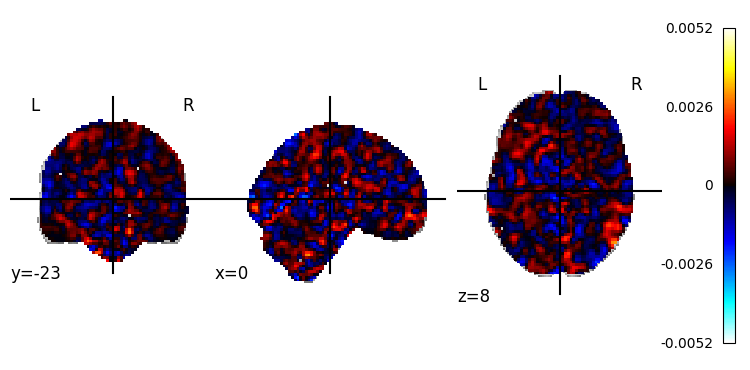

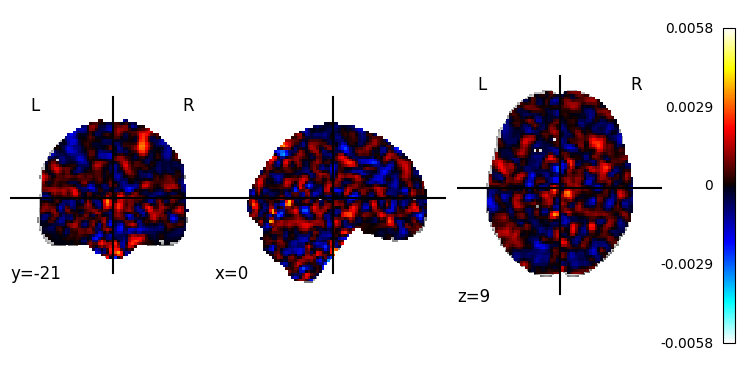

In [87]:
plotting.plot_stat_map(vic_img)
plotting.plot_stat_map(pain_img)
plotting.plot_stat_map(cog_img)

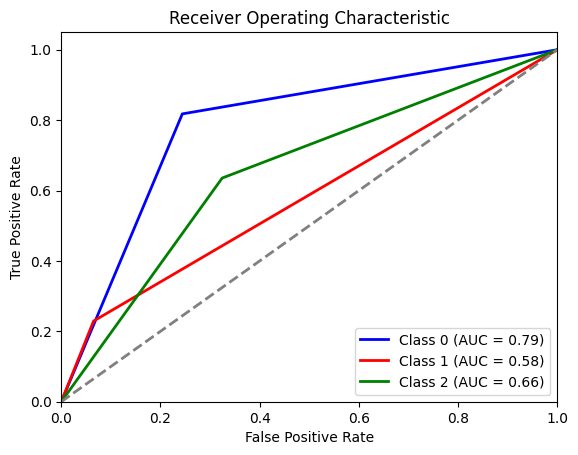

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming Y_test and Y_pred are the true labels and predicted labels
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
# Calculate ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, Y_pred == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green']  # Adjust colors as needed
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming num_classes is the number of classes
num_classes = 3  # Update this based on your actual number of classes

# Calculate ROC curve and AUC for each class across all folds
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i] = []
    tpr[i] = []
    for Y_test, Y_pred_proba in zip(y_tests, y_pred_probas):
        fpr_tmp, tpr_tmp, _ = roc_curve(Y_test == i, Y_pred_proba[:, i])
        fpr[i].append(fpr_tmp)
        tpr[i].append(tpr_tmp)
        roc_auc[i] = auc(fpr_tmp, tpr_tmp)
    
    # You might want to average the FPRs and TPRs across folds or plot them individually
    # For simplicity, here's how you might plot the ROC curve for each class
    plt.figure()
    plt.plot(fpr[i][0], tpr[i][0], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')  # Example for first fold
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {i}')
    plt.legend(loc="lower right")
    plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## 2) y pred and y values

ValueError: x and y must be the same size

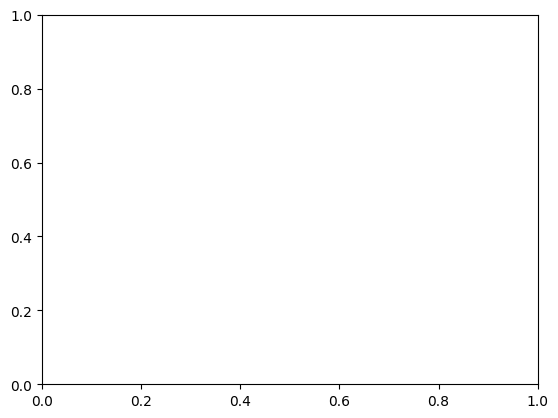

In [22]:
import numpy as np

# Add jitter to Y_pred for visualization
jitter = np.random.uniform(-0.1, 0.1, size=len(Y_pred))
Y_pred_jittered = Y_pred + jitter

plt.scatter(Y, Y_pred_jittered, alpha=0.5)
plt.xlabel('True Labels (Y)')
plt.ylabel('Predicted Labels (Y_pred)')
plt.title('True vs. Predicted Labels')
plt.show()


In [ ]:
## 3) brain maps
import numpy as np

# Add jitter to Y_pred for visualization
jitter = np.random.uniform(-0.1, 0.1, size=len(Y_pred))
Y_pred_jittered = Y_pred + jitter

plt.scatter(Y, Y_pred_jittered, alpha=0.5)
plt.xlabel('True Labels (Y)')
plt.ylabel('Predicted Labels (Y_pred)')
plt.title('True vs. Predicted Labels')
plt.show()


In [ ]:
# ... (code for training and testing SVM as shown previously)

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(Y))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, Y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot confusion matrix
plt.subplot(1, 2, 2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = [f'Class {i}' for i in range(n_classes)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.tight_layout()

# Show the plots
plt.show()


Confusion matrix

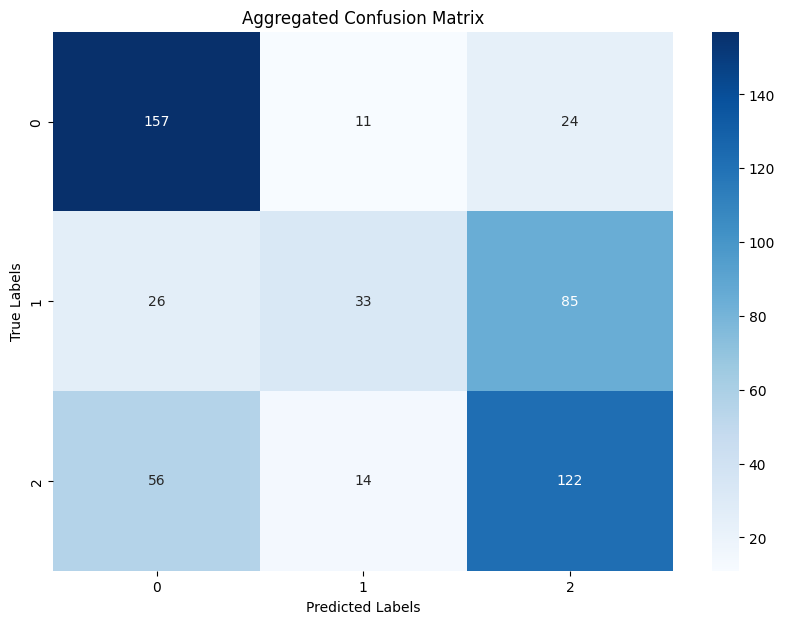

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Aggregated Confusion Matrix')
plt.show()


# tryout 2

In [32]:
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np

# Example dataset
# X: feature matrix, y: target labels, groups: participant identifiers

# Define the SVM classifier
clf = SVC(kernel='linear', decision_function_shape='ovr')

# Define the cross-validation strategy, ensuring participants are not split across folds
cv = GroupKFold(n_splits=5)

# Perform cross-validation
scores = cross_val_score(clf, X, Y, groups=groups, cv=cv, scoring=make_scorer(accuracy_score))

# Print the average accuracy
print(scores)
print(f'Average accuracy: {scores.mean()}')


[0.325 0.32  0.34  0.29  0.345]
Average accuracy: 0.324
